In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

%matplotlib inline

In [3]:
def filterDataset(data):
    invalidIndexes = []
    for row in data.itertuples():
        if '?' in row:
            invalidIndexes.append(row[0])
    new_data = data.drop(data.index[invalidIndexes])
    cols = list(new_data.columns)
    new_data[cols] = new_data[cols].astype('float32')
    return new_data

In [60]:
def train_and_test():
    data = pd.read_csv('processed.cleveland.data', names=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'], header=None)
    data = filterDataset(data)
    ## split data into train and test
    cols = list(data.columns)
    cols.remove('num')
    target = data['num'].copy()
    input_data = data[cols].copy()
    target_bin = label_binarize(target, classes=[0, 1, 2, 3, 4])
    global targetTest
    dTrain, dTest, targetTrain, targetTest = train_test_split(input_data, target_bin, test_size=0.20, stratify=target_bin)
    scaler = preprocessing.StandardScaler().fit(dTrain)
    dTrain = scaler.transform(dTrain)
    ovr = OneVsRestClassifier(SVC(kernel='linear', probability=True, class_weight='balanced', random_state=0), n_jobs=-1)
    ovr.fit(dTrain, targetTrain)
    y_score = ovr.decision_function(dTest)
    dTest = scaler.transform(dTest)
    pred = ovr.predict(dTest)
    score = ovr.score(dTest, targetTest)
    targetTest_nonbin = np.asarray([np.argmax(c) for c in targetTest])
    pred = np.asarray([np.argmax(c) for c in pred])
    cm = confusion_matrix(targetTest_nonbin, pred, labels=[0,1,2,3,4])
    score = np.sum(np.diagonal(cm))/np.sum(cm)
    np.savetxt("confusion_matrix_ova.csv", cm, delimiter=",")
    
    return score, y_score

In [64]:
targetTest = 0
scores = []
y_score_final = 0
for i in tqdm(range(100)):
    score, y_score = train_and_test()
    scores.append(score)
    y_score_final += y_score
    
scores = np.asarray(scores)
print(scores.mean())
print(scores.std())
y_score_final /= 100

  0%|          | 0/1 [00:00<?, ?it/s]100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

0.616666666667
0.0
(60, 5)


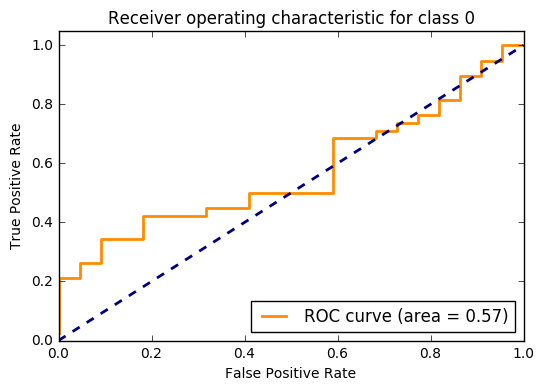

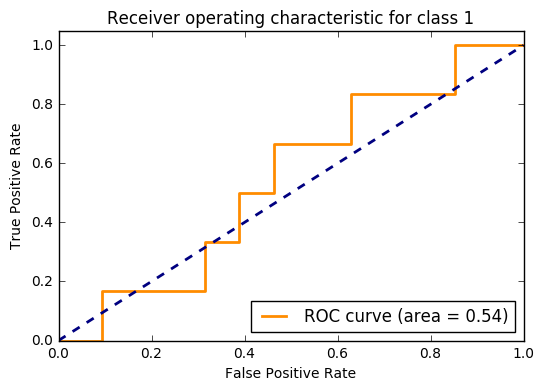

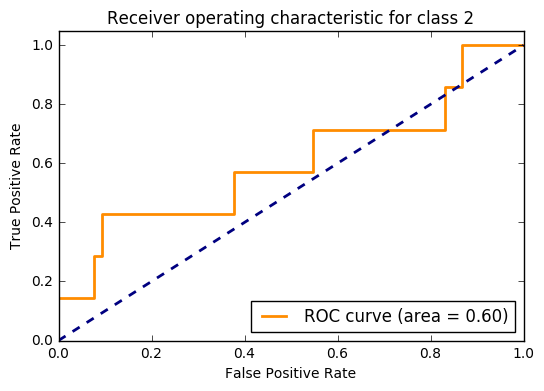

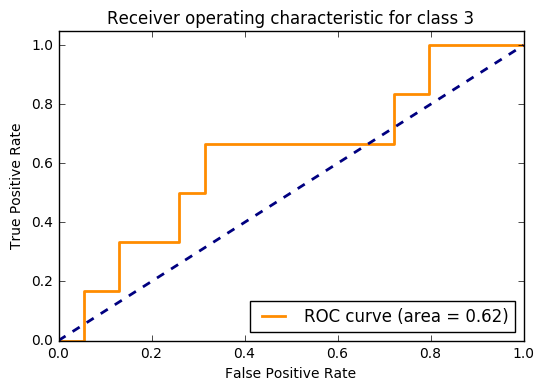

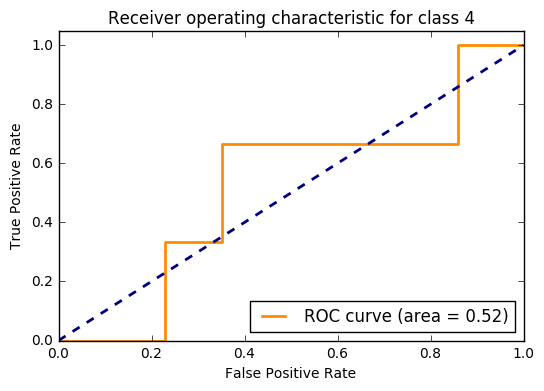

In [62]:
#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(targetTest[:, i], y_score_final[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
for i in range(5):
    plt.figure()
    lw = 2
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class ' + str(i))
    plt.legend(loc="lower right")

    plt.show()


In [8]:
ova = pd.read_csv('confusion_matrix_ova.csv', header=None)
ava = pd.read_csv('confusion_matrix_ava.csv', header=None)
print(ova, '\n',ava)

      0    1    2    3    4
0  31.0  1.0  0.0  0.0  0.0
1   3.0  2.0  0.0  3.0  0.0
2   3.0  0.0  0.0  4.0  1.0
3   1.0  2.0  1.0  3.0  1.0
4   2.0  1.0  0.0  1.0  0.0 
       0    1    2    3    4
0  39.0  0.0  0.0  0.0  0.0
1   8.0  0.0  0.0  0.0  0.0
2   6.0  0.0  0.0  0.0  0.0
3   6.0  0.0  0.0  0.0  0.0
4   1.0  0.0  0.0  0.0  0.0
